# National Oceanic and Atmospheric Administration (NOAA)
This jupyter notebook is meant to be used along with the North American Mesoscale Forecast System (NAM) dataset.  
This dataset can be found online under "Data Access > Model > Datasets > NAM" on the NOAA website.  
Once the data has been properly requested, confirmed, and processed using NOAA's Order Data feature,  
the requester is given 5 days to download the data via a email-link.  

# NAM 2017
To be more specific, the range this notebook will be targetting is the entire 2017 year (1800 UTC only). (100 ish Gb)  
Through further observation of the email-link provided by NOAA, it can be seen that the files end in an extension ".tar". These are all just zipped files. BEWARE- unpacking all these files doubles the 100Gb to 200Gb.  
It is recommended to make a main folder (moddata) with subfolders with each month on them (01, 02, 03, ..., 12).  
Then, putting all the corresponding ".tar" files in their respective month folder. The idea is to unpack an entire month and then delete the ".tar" files for that month. That way you don't have to unpack 100Gb to 200Gb and then try to delete 100Gb. It will be more like unpacking 6Gb to 12Gb then deleting the old 6Gb.

# Unpacking ".tar" Files
The ".tar" file names should look like the following:

namanl_218_2017010118.g2.tar

The format is very simple: namanl_218_yyyymmddhh.g2.tar  
Where yyyy = year, mm = month, dd = day, hh = hour (UTC)  
The above file would then be of 2017 January 1st 18 UTC

Since this data ranges accross the entire North America continent, 18 UTC was chosen. In New York, 18 UTC translates to 2 P.M. This makes any "real images" from the dataset appear more visually appealing since that part of the Earth will be facing towards the sun. This would be better than "real images" of NA taken at night. This also saves a lot of space. Imagine simply having 2 timestamps per day instead of 1, this would easily double the size of the data. NOAA allows 4 timestamps per day (0 UTC, 6 UTC, 12 UTC, and 18 UTC).  

Once you're inside the month directory containing all the ".tar" files for that month, simply use the following command to unpack:

// assuming path /moddata/01 being the path to all of january's ".tar" files type  
// and that you are currently inside the /01 directory, type the following into the kernel:  
for f in *.tar; do tar -xvf $f; done

This command should run for about 20 seconds and you should see all the files being unpacked individually.  
For every ".tar" file unpacked, there should be 5 ".grb2" files

// now type the following command to delete all of the ".tar" files in that directory:  
rm -r *.tar

This is done for all 12 months until every subdirectory of /moddata contains only ".grb2" files.  
The new file format should be:

nam_218_20170101_1800_000.grb2

nam_218_yyyymmdd_hhhh_band.grb2

# Congratulations!
Once all of the ".grb2" for every month are neatly organized in their own folder, the Exploritory Data Analysis can begin!  
These files can be viewed using a python package called "pygrib".  
Currently, pygrib is not available on windows (or at-least too hard to install), so the following commands and codes were performed on a Virtual Machine running Ubuntu 16.04 LTS with Anaconda2-Python 2.7 installed. Details on how to create your own Virtual Machine and install a Linux distribution can be found online. Once it's set up and working, simply go on a web-browser, on the virtual machine, and google "Anaconda Python", follow the instructions to install Anaconda2-Python 2.7 for Linux.  

// to ensure everything downloaded correctly, go on any terminal and type in
python -V

This should return "Python 2.7.14 :: Anaconda, Inc" or a newer version.  
Now to install the pygrib package using anaconda. Type the following into a terminal:

conda install -c conda-forge pygrib

That's about it for installations. Now let's dive into the code--

In [1]:
import pygrib # used to view ".grb2" files
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def print_grbs(grbs):
    """
    grbs = pygrib.open("filepath.grb2")
    """
    for grb in grbs:
        print(grb)

In [81]:
def list_year(filepath):
    """
    filepath: a string that includes the filepath to the folder containing all the months
    Example: filepath = "/mnt/moddata" , output = {"/mnt/moddata/01/nam_218_20170101_1800_000.grb2", ...} 
    for all filepaths of the year 2017
    """
    subfolders = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    month_days = ["31", "28", "31", "30", "31", "30", "31", "31", "30", "31", "30", "31"]
    bands = ["0", "1", "2", "3", "6"]
    lst = [] # an empty list
    
    for i in range(len(subfolders)):
        for j in range(1,int(month_days[i])):
            for k in range(len(bands)):
                if (j <= 9): 
                    lst.append(filepath + "/" + subfolders[i] + "/nam_218_2017" + subfolders[i] + "0" + str(j) +"_1800_00" + bands[k] + ".grb2")
                elif (j > 9 and j <= 19): 
                    lst.append(filepath + "/" +subfolders[i] + "/nam_218_2017" + subfolders[i] + str(j) +"_1800_00" + bands[k] + ".grb2")
                elif (j > 19 and j <= 29): 
                    lst.append(filepath + "/" +subfolders[i] + "/nam_218_2017" + subfolders[i] + str(j) +"_1800_00" + bands[k] + ".grb2")     
                else:
                    lst.append(filepath + "/" +subfolders[i] + "/nam_218_2017" + subfolders[i] + str(j) +"_1800_00" + bands[k] + ".grb2")
                
    return lst

In [85]:
path = "/mnt/moddata" # this is the path to the directory containing all the subdirectories 01, 02, 03, 04, etc
paths = list_year(path) # this function returns a list of all filepaths starting from the path above
print(paths[0]) # should print the filepath for 2017 January 1st Band 0

/mnt/moddata/01/nam_218_20170101_1800_000.grb2


In [87]:
# let's view the very first data file 
jan_01_0 = paths[0] # path to january 1st band 0
grbs = pygrib.open(jan_01_0)
print(type(grbs)) # this should print <type 'pygrib.open'> if successful

<type 'pygrib.open'>


In [88]:
# let's take a look inside this file
print_grbs(grbs)

1:MSLP (Eta model reduction):Pa (instant):lambert:meanSea:level 0:fcst time 0 hrs:from 201701011800
2:Pressure reduced to MSL:Pa (instant):lambert:meanSea:level 0:fcst time 0 hrs:from 201701011800
3:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
4:Orography:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
5:Temperature:K (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
6:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201701011800
7:2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201701011800
8:Relative humidity:% (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201701011800
9:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:from 201701011800
10:10 metre V wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:from 201701

112:Temperature:K (instant):lambert:isobaricInhPa:level 27500 Pa:fcst time 0 hrs:from 201701011800
113:Relative humidity:% (instant):lambert:isobaricInhPa:level 27500 Pa:fcst time 0 hrs:from 201701011800
114:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 27500 Pa:fcst time 0 hrs:from 201701011800
115:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 27500 Pa:fcst time 0 hrs:from 201701011800
116:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 27500 Pa:fcst time 0 hrs:from 201701011800
117:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 30000 Pa:fcst time 0 hrs:from 201701011800
118:Temperature:K (instant):lambert:isobaricInhPa:level 30000 Pa:fcst time 0 hrs:from 201701011800
119:Relative humidity:% (instant):lambert:isobaricInhPa:level 30000 Pa:fcst time 0 hrs:from 201701011800
120:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 30000 Pa:fcst time 0 hrs:from 201701011800
121:V component of wind:m

203:Relative humidity:% (instant):lambert:isobaricInhPa:level 65000 Pa:fcst time 0 hrs:from 201701011800
204:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 65000 Pa:fcst time 0 hrs:from 201701011800
205:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 65000 Pa:fcst time 0 hrs:from 201701011800
206:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 65000 Pa:fcst time 0 hrs:from 201701011800
207:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 67500 Pa:fcst time 0 hrs:from 201701011800
208:Temperature:K (instant):lambert:isobaricInhPa:level 67500 Pa:fcst time 0 hrs:from 201701011800
209:Relative humidity:% (instant):lambert:isobaricInhPa:level 67500 Pa:fcst time 0 hrs:from 201701011800
210:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 67500 Pa:fcst time 0 hrs:from 201701011800
211:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 67500 Pa:fcst time 0 hrs:from 201701011800
212:Turbule

296:Volumetric soil moisture content:Proportion (instant):lambert:depthBelowLandLayer:levels 0.4-1.0 m:fcst time 0 hrs:from 201701011800
297:Soil Temperature:K (instant):lambert:depthBelowLandLayer:levels 1.0-2.0 m:fcst time 0 hrs:from 201701011800
298:Volumetric soil moisture content:Proportion (instant):lambert:depthBelowLandLayer:levels 1.0-2.0 m:fcst time 0 hrs:from 201701011800
299:Surface roughness:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
300:Drag coefficient:Numeric (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
301:Sensible heat net flux:W m**-2 (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
302:Latent heat net flux:W m**-2 (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
303:Downward short-wave radiation flux:W m**-2 (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701011800
304:Downward long-wave radiation flux:W m**-2 (instant):lambert:surface:level 0:fcst time 0 hrs:from 20170

392:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 1000 Pa:fcst time 0 hrs:from 201701011800
393:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 2000 Pa:fcst time 0 hrs:from 201701011800
394:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 0 hrs:from 201701011800
395:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 7500 Pa:fcst time 0 hrs:from 201701011800
396:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 10000 Pa:fcst time 0 hrs:from 201701011800
397:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 12500 Pa:fcst time 0 hrs:from 201701011800
398:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 15000 Pa:fcst time 0 hrs:from 201701011800
399:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 17500 Pa:fcst time 0 hrs:from 201701011800
400:Geometric vertical velocity:m s*

In [89]:
# by looking at the data above, the unit for temperature is kelvin (K)
# there are multiple ways to extract data from a given "row"
# .values is a numpy command used to return a numpy array
temp_surf = grbs.select(name="Temperature")[0].values # temperature at the surface
temp_2m = grbs.select(name="2 metre temperature")[0].values # temperature at 2m
temp_5000 = grbs[58].values # index 58 is temperature at 5000m
snow_depth = grbs[364].values # index 364 is snow depth
soil_temp = grbs.select(name="Soil Temperature")[0].values
lightning = grbs.select(name="Lightning")[0].values

In [95]:
# let's just see what all these array's look like
print(temp_surf)
#print(temp_2m)
#print(temp_5000)
#print(snow_depth)
#print(soil_temp)
#print(lightning)

[[300.21150208 300.08650208 300.08650208 ... 301.21150208 300.83650208
  300.83650208]
 [299.96150208 300.08650208 300.08650208 ... 300.96150208 300.96150208
  300.96150208]
 [299.71150208 299.96150208 300.21150208 ... 300.83650208 301.08650208
  300.83650208]
 ...
 [278.83650208 278.96150208 279.08650208 ... 276.33650208 276.46150208
  276.46150208]
 [278.96150208 279.08650208 279.21150208 ... 276.58650208 276.58650208
  276.46150208]
 [278.96150208 278.96150208 278.83650208 ... 276.58650208 276.58650208
  276.46150208]]


318.2115020751953


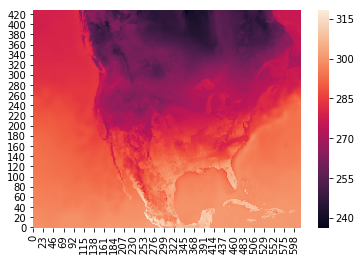

In [68]:
# lets try printing some of this data
# this should print out a heatmap in the shape of NA. As the altitude increases the temperature decreases
ax = sns.heatmap(temp_surf, cbar='true')
ax.invert_yaxis() # heatmap would print it upside down if it wasn't for this
print(np.max(temp_surf))

306.42022705078125


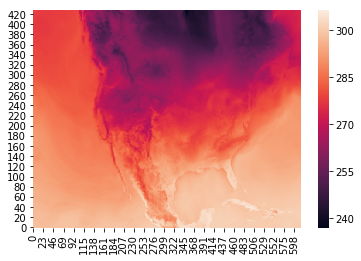

In [69]:
ax = sns.heatmap(temp_2m, cbar='true')
ax.invert_yaxis()
print(np.max(temp_2m))

221.26348876953125


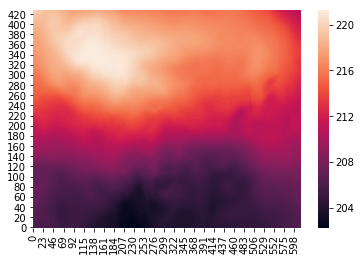

In [70]:
ax = sns.heatmap(temp_5000, cbar='true')
ax.invert_yaxis()
print(np.max(temp_5000))

5.035200000000001


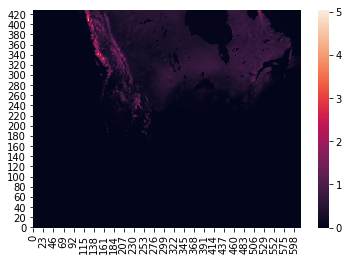

In [71]:
ax = sns.heatmap(snow_depth, cbar='true')
ax.invert_yaxis()
print(np.max(snow_depth))

1.0


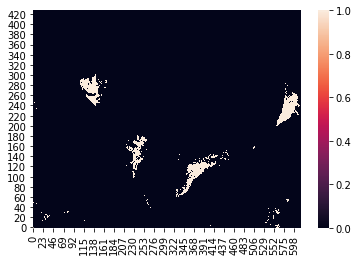

In [96]:
ax = sns.heatmap(lightning, cbar='true')
ax.invert_yaxis()
print(np.max(lightning))